#### Necessary Libraries

In [83]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
from datetime import datetime
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# feature scaling & OHE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler # data encoders

# moodels 
import xgboost as xgb
from xgboost import plot_importance

# evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, average_precision_score, precision_recall_curve

# resampling techniques for imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler #
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek



# formatting 
%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Reading Data 
- Training Datasets: X_train, y_train
- Validation Datasets: X_val, y_val

*Note: they are in a folder one level higher than current folder*

In [37]:
X_train = pd.read_csv('../X_train.csv')
X_val = pd.read_csv('../X_val.csv')
y_train = pd.read_csv('../y_train.csv')
y_val = pd.read_csv('../y_val.csv')

# test set only for one-time assessment of final model
X_test = pd.read_csv('../X_test.csv')
y_test = pd.read_csv('../y_test.csv')

In [38]:
X_train.head()

,hour_of_day,day_of_week,category,gender,age_group,state,job_category,distance,amount(usd)
0,15,Monday,kids_pets,F,21-40,NY,C2,52.770575,75.72
1,10,Tuesday,gas_transport,F,41-60,CA,C2,68.181551,79.74
2,20,Monday,home,M,41-60,MT,C4,66.904380,74.92
3,0,Saturday,gas_transport,F,0-20,IL,C2,65.195819,44.30
4,18,Saturday,home,M,41-60,MD,C2,71.833218,28.02


In [39]:
print("X_train's Shape:",X_train.shape)
print("X_val's Shape:",X_val.shape)
print("X_test's Shape:",X_test.shape)

X_train's Shape: (1481915, 9)
X_val's Shape: (185239, 9)
X_test's Shape: (185240, 9)


#### Local Preprocessing

Creating a **Pipeline*** for the following preprocessing steps:
- Feature Scaling for Numerical Features
- One-Hot Encoding for Categorical Features

****Pipeline()** helps to streamline processes especially since we are refining our models using different techniques like under/oversampling, hyperparameter tuning, etc.*

In [40]:
# numerical features - StandardScaler()
numerical_cols = ['hour_of_day', 'distance', 'amount(usd)']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


# categorical features - OneHotEncoder()
categorical_cols = ['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combining preprocessing pipelines for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

#### Helper Functions for Evaluating Model Performance 
a. Evaluate Model using Recall, Precision, F1, Accuracy, ROC AUC, PR AUC

b. Confusion Matrix showing TP,FP,TN,FN

In [41]:
def evaluate_model(y_true, y_pred, y_pred_prob, model_name):
    metrics = {
        'Precision':precision_score(y_true, y_pred),
        'Recall':recall_score(y_true, y_pred),
        'F1 Score':f1_score(y_true, y_pred),
        'PR AUC': average_precision_score(y_true, y_pred_prob), # precision-recall AUC
        'ROC AUC': roc_auc_score(y_true, y_pred_prob)
}

    metrics_df = pd.DataFrame([metrics], index =[model_name])
    return metrics_df

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(model_name)
    plt.show()

#### 1. Baseline Model for XGBoost

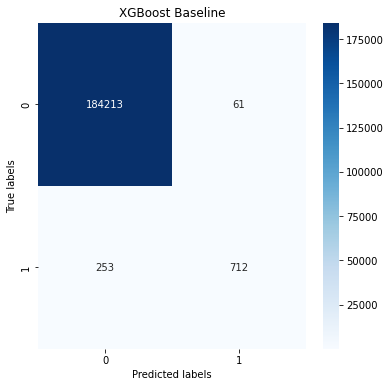

In [42]:
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

base_model.fit(X_train, y_train)

y_val_pred = base_model.predict(X_val)
y_val_pred_prob = base_model.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='XGBoost Baseline')

In [43]:
base_model_results = evaluate_model(y_true=y_val,
                                    y_pred=y_val_pred, 
                                    y_pred_prob=y_val_pred_prob,
                                    model_name='XGBoost Baseline')
base_model_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758


Insights

#### 2. Addressing Class Imbalance 
**a. Synthetic Minority Over-sampling Technique (SMOTE)**

Since our dataset exhibits significant class imbalance (i.e. non-fraudulent >> fraudulent transactions), this can lead to a model being biased towards the majority class, often resulting in poor detection of the minority class (i.e. fraudulent transactions). 

Unlike random oversampling, SMOTE generates synthetic samples rather than simply duplicating existing ones. This approach helps in creating a more diverse and representative sample of the minority class, potentially leading to better generalization Thereby aiding the model in learning patterns specific to fraudulent transactions. Leading to higher recall/sensitivity, making the model more capable of detecting actual fraud cases.

ImbPipeline allows inclusion of resampling step within pipeline, ensuring that resampling only happens during training phase


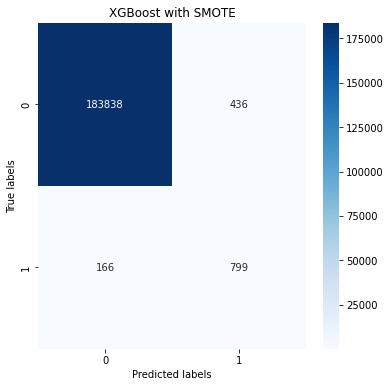

In [44]:
model_SMOTE = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_SMOTE
model_SMOTE.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_SMOTE.predict(X_val)
y_val_pred_prob = model_SMOTE.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='XGBoost with SMOTE')

In [45]:
model_SMOTE_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='XGBoost with SMOTE')
model_SMOTE_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076


In [46]:
results_df = pd.concat([base_model_results, model_SMOTE_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076




**Analysis**:


**b. Random Undersampling**


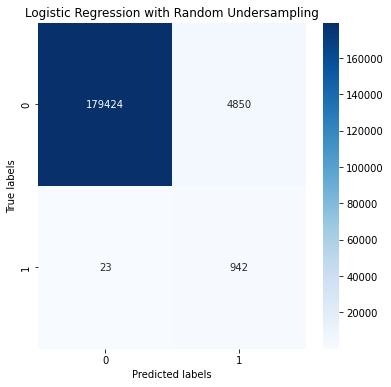

In [47]:
model_RUS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_RUS
model_RUS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_RUS.predict(X_val)
y_val_pred_prob = model_RUS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with Random Undersampling')

In [48]:
model_RUS_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='XGBoost with Random Undersampling')
model_RUS_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167


In [49]:
results_df = pd.concat([results_df, model_RUS_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167


**d. Random Oversampling**

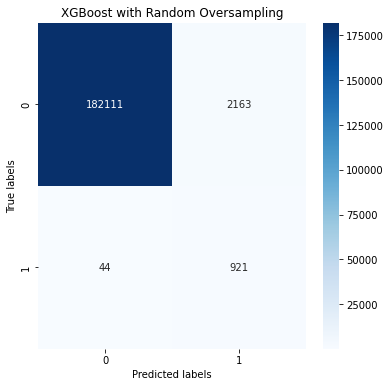

In [50]:
model_ROS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomOverSampler(random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# train model_ROS
model_ROS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_ROS.predict(X_val)
y_val_pred_prob = model_ROS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='XGBoost with Random Oversampling')

In [51]:
model_ROS_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='XGBoost with Random Oversampling')
model_ROS_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851


In [52]:
results_df = pd.concat([results_df, model_ROS_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851


## 3. Hyperparamter Tuning

In [53]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

a. Baseline Model

In [54]:
randomized_search = RandomizedSearchCV(base_model, param_grid, cv=5, scoring='f1', verbose=2)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__subsample=1.0; total time=   8.1s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__subsample=1.0; total time=   8.3s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__subsample=1.0; total time=   9.5s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=100, classifier__subsample=1.0; total time=   8.3s
[CV] END classi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hour_of_day',
                                                                                'distance',
                                                                                'amount(usd)']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncod...
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='f1', verbose=2)

In [55]:
est_params_baseline = randomized_search.best_params_
best_model_baseline = randomized_search.best_estimator_

In [56]:
# Evaluate the best model on the validation set
y_val_pred_best_baseline = best_model_baseline.predict(X_val)
y_val_pred_prob_best_baseline = best_model_baseline.predict_proba(X_val)[:, 1]

In [57]:
# evaluation metrics for the best model
base_model_tuned_results = evaluate_model(y_true=y_val,
                                          y_pred=y_val_pred_best_baseline, 
                                          y_pred_prob=y_val_pred_prob_best_baseline,
                                          model_name='XGBoost Baseline (Tuned)')
base_model_tuned_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline (Tuned),0.926166,0.740933,0.823258,0.882283,0.997497


In [58]:
results_df = pd.concat([results_df, base_model_tuned_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851
XGBoost Baseline (Tuned),0.926166,0.740933,0.823258,0.882283,0.997497


b. SMOTE 

In [59]:
randomized_search = RandomizedSearchCV(model_SMOTE, param_grid, cv=5, scoring='f1', verbose=2)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200, classifier__subsample=0.6; total time=  25.6s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200, classifier__subsample=0.6; total time=  25.7s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200, classifier__subsample=0.6; total time=  27.8s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200, classifier__subsample=0.6; total time=  28.5s
[CV] END classi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hour_of_day',
                                                                                'distance',
                                                                                'amount(usd)']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncod...
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='f1', verbose=2)

In [60]:
best_params_SMOTE = randomized_search.best_params_
best_model_SMOTE = randomized_search.best_estimator_

In [61]:
# Evaluate the best model on the validation set
y_val_pred_best_SMOTE = best_model_SMOTE.predict(X_val)
y_val_pred_prob_best_SMOTE = best_model_SMOTE.predict_proba(X_val)[:, 1]

In [62]:
# evaluation metrics for the best model
model_SMOTE_tuned_results = evaluate_model(y_true=y_val,
                                          y_pred=y_val_pred_best_SMOTE, 
                                          y_pred_prob=y_val_pred_prob_best_SMOTE,
                                          model_name='XGBoost with SMOTE (Tuned)')
model_SMOTE_tuned_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with SMOTE (Tuned),0.794326,0.812435,0.803279,0.873263,0.997312


In [63]:
results_df = pd.concat([results_df, model_SMOTE_tuned_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851
XGBoost Baseline (Tuned),0.926166,0.740933,0.823258,0.882283,0.997497
XGBoost with SMOTE (Tuned),0.794326,0.812435,0.803279,0.873263,0.997312


c. Random Undersampling

In [66]:
randomized_search = RandomizedSearchCV(model_RUS, param_grid, cv=5, scoring='f1', verbose=2)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__subsample=0.6; total time=   4.4s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__subsample=0.6; total time=   4.3s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__subsample=0.6; total time=   4.1s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.2, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__min_child_weight=5, classifier__n_estimators=100, classifier__subsample=0.6; total time=   4.1s
[CV] END classifier

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hour_of_day',
                                                                                'distance',
                                                                                'amount(usd)']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncod...
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='f1', verbose=2)

In [67]:
best_params_RUS = randomized_search.best_params_
best_model_RUS = randomized_search.best_estimator_

In [68]:
# Evaluate the best model on the validation set
y_val_pred_best_RUS = best_model_RUS.predict(X_val)
y_val_pred_prob_best_RUS = best_model_RUS.predict_proba(X_val)[:, 1]

In [69]:
# evaluation metrics for the best model
model_rus_tuned_results = evaluate_model(y_true=y_val,
                                          y_pred=y_val_pred_best_RUS, 
                                          y_pred_prob=y_val_pred_prob_best_RUS,
                                          model_name='XGBoost with Random Undersampling (Tuned)')
model_rus_tuned_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with Random Undersampling (Tuned),0.166078,0.97513,0.283818,0.812729,0.99725


In [70]:
results_df = pd.concat([results_df, model_rus_tuned_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851
XGBoost Baseline (Tuned),0.926166,0.740933,0.823258,0.882283,0.997497
XGBoost with SMOTE (Tuned),0.794326,0.812435,0.803279,0.873263,0.997312
XGBoost with Random Undersampling (Tuned),0.166078,0.975130,0.283818,0.812729,0.997250


d. Random Oversampling

In [71]:
randomized_search = RandomizedSearchCV(model_ROS, param_grid, cv=5, scoring='f1', verbose=2)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__subsample=0.8; total time=  29.8s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__subsample=0.8; total time=  33.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__subsample=0.8; total time=  39.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0.1, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__min_child_weight=3, classifier__n_estimators=300, classifier__subsample=0.8; total time=  36.4s
[CV] END classifier

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hour_of_day',
                                                                                'distance',
                                                                                'amount(usd)']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncod...
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   param_distributions={'classifier__colsample_bytree': [0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   scoring='f1', verbose=2)

In [72]:
best_params_ROS = randomized_search.best_params_
best_model_ROS = randomized_search.best_estimator_

In [73]:
# Evaluate the best model on the validation set
y_val_pred_best_ROS = best_model_ROS.predict(X_val)
y_val_pred_prob_best_ROS = best_model_ROS.predict_proba(X_val)[:, 1]

In [74]:
# evaluation metrics for the best model
model_ros_tuned_results = evaluate_model(y_true=y_val,
                                          y_pred=y_val_pred_best_ROS, 
                                          y_pred_prob=y_val_pred_prob_best_ROS,
                                          model_name='XGBoost with Random Oversampling (Tuned)')
model_ros_tuned_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost with Random Oversampling (Tuned),0.362267,0.94715,0.524083,0.885021,0.998151


In [75]:
results_df = pd.concat([results_df, model_ros_tuned_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
XGBoost Baseline,0.921087,0.737824,0.819333,0.886572,0.997758
XGBoost with SMOTE,0.646964,0.827979,0.726364,0.848459,0.996076
XGBoost with Random Undersampling,0.162638,0.976166,0.278822,0.795118,0.997167
XGBoost with Random Oversampling,0.298638,0.954404,0.454927,0.877423,0.997851
XGBoost Baseline (Tuned),0.926166,0.740933,0.823258,0.882283,0.997497
XGBoost with SMOTE (Tuned),0.794326,0.812435,0.803279,0.873263,0.997312
XGBoost with Random Undersampling (Tuned),0.166078,0.975130,0.283818,0.812729,0.997250
XGBoost with Random Oversampling (Tuned),0.362267,0.947150,0.524083,0.885021,0.998151


Best XGB Model: Baseline with Hyperparameters Tuned

In [77]:
est_params_baseline

{'classifier__subsample': 0.8,
 'classifier__n_estimators': 200,
 'classifier__min_child_weight': 5,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0.2,
 'classifier__colsample_bytree': 1.0}

## One-Time Assessment of Best XGB Model on Testing Set
To understand model performance on unseen data.

In [94]:
best_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, **est_params_baseline))
])

best_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'distance',
                                                   'amount(usd)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['d...
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, ...))])

Evaluate on Testing Set

In [96]:
y_test_pred = best_xgb_model.predict(X_test)
y_test_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1] # probabilities for ROC AUC

In [97]:
# evaluation metrics for the best model
best_xgb_model_results = evaluate_model(y_true=y_test,
                                        y_pred=y_test_pred, 
                                        y_pred_prob=y_test_pred_prob,
                                        model_name='Best XGB Model (Base Model with Hyperparameters Tuned')
best_xgb_model_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Best XGB Model (Base Model with Hyperparameters Tuned,0.927227,0.765803,0.83882,0.904084,0.998417


## Feature Importance 

In [98]:
ohe = (best_xgb_model.named_steps['preprocessor']
             .named_transformers_['cat']
             .named_steps['onehot'])

In [99]:
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)
all_feature_names

['hour_of_day',
 'distance',
 'amount(usd)',
 'day_of_week_Friday',
 'day_of_week_Monday',
 'day_of_week_Saturday',
 'day_of_week_Sunday',
 'day_of_week_Thursday',
 'day_of_week_Tuesday',
 'day_of_week_Wednesday',
 'category_entertainment',
 'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel',
 'gender_F',
 'gender_M',
 'age_group_0-20',
 'age_group_21-40',
 'age_group_41-60',
 'age_group_61-80',
 'age_group_81-100',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state

In [100]:
fitted_xgb_classifier = best_xgb_model.named_steps['classifier']
fitted_xgb_classifier.get_booster().feature_names = all_feature_names

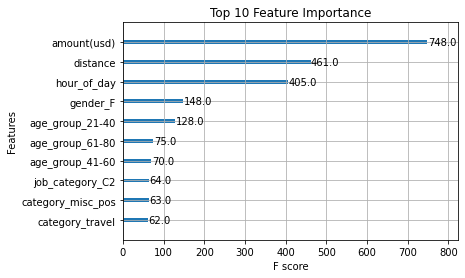

In [101]:
plot_importance(fitted_xgb_classifier, max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()